In [1]:
from pytorch_lightning.utilities import grad_norm
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
from sklearn.metrics import silhouette_score
import pandas as pd 
import torch.optim as optim
from braingeneers.analysis import SpikeData
import os
import json
import pytorch_lightning as pl
from backbones import ResNet18Enc, ResNet18Dec
import wandb
import pickle
from tqdm import tqdm
import scanpy as sc 
import matplotlib.pyplot as plt 
from torch.optim.lr_scheduler import ReduceLROnPlateau
import anndata as an 
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
import umap
from collections import Counter


In [15]:
# #File loader for the non labeled data
# waveform_files = ["data/" + f for f in os.listdir("./data") if f.endswith('.npy')]
# meta_files = [f.replace('.npy', '.json') for f in waveform_files]

# waveforms = []
# isi_dist = []

# for wf, mf in zip(waveform_files, meta_files):
#     with open(mf, 'r') as file:
#         json_data = json.load(file)

#     sd = SpikeData([json_data[key]['train'] for key in json_data.keys()])
#     trains = sd.train

#     all_isi = sd.interspike_intervals()
    
#     bad_indices = []
#     for idx, isi in enumerate(all_isi):
#         hist, _ = np.histogram(isi[isi < 0.1], bins=64, density=True)
#         if not np.isnan(hist).all():
#             isi_dist.append(hist)
#         else:
#             bad_indices.append(idx)
    
#     waveform_data = np.load(wf)
#     if bad_indices:
#         waveform_data = np.delete(waveform_data, np.array(bad_indices), axis=0)

#     waveforms.append(waveform_data)
# waveforms = np.concatenate(waveforms, axis=0)
# isi_dist = np.stack(isi_dist)


In [2]:
waveform_files = ["unlabeled_data_templates/processed_data/" + f for f in os.listdir("./unlabeled_data_templates/processed_data/") if f.endswith('templates.npy')]
meta_files = [f.replace('templates.npy', 'isi_distribution.npy') for f in waveform_files]
waveforms = []
isi_dist = []
for wf, mf in zip(waveform_files, meta_files):
    waveform = np.load(wf)
    #print(waveform.shape)
    if waveform.shape[1] == 0:
        continue
    else:
        waveform = np.squeeze(waveform, axis=0)
        isi_dis = np.load(mf)
        #print(waveform.shape)
        #print(isi_dis.shape)
        waveforms.append(waveform)
        isi_dist.append(isi_dis)

waveforms = np.concatenate(waveforms, axis=0)
waveforms = (waveforms - waveforms.mean()) / waveforms.std()
#0 1 normalization
#waveforms = (waveforms - waveforms.min()) / (waveforms.max() - waveforms.min())

isi_dists = np.concatenate(isi_dist)
isi_dists = isi_dists / isi_dists.sum(axis=1, keepdims=True)


In [3]:
len(waveforms), len(isi_dists)

(1427, 1427)

In [4]:
#Dataloader dataset
class EphysDataset(Dataset):
    def __init__(self, waveforms, isi_dists, normalize=True):
        self.waveforms = np.array(waveforms)
        self.isi_dists = np.array(isi_dists)
        
        assert len(self.waveforms) == len(self.isi_dists)
        self.normalize = normalize
        
    def __getitem__(self, idx):
        waveform = torch.as_tensor(self.waveforms[idx, ...]).float()
        
        isi_dist = torch.as_tensor(self.isi_dists[idx, ...]).float()
        isi_dist = torch.log(isi_dist + 1)

        if self.normalize:
            #waveform = (waveform - waveform.mean()) / waveform.std()
            #0 1 normalization
            waveform = (waveform - waveform.min()) / (waveform.max() - waveform.min())
            isi_dist = (isi_dist - isi_dist.mean()) / isi_dist.std()

        waveform = waveform.view(1, 1, -1)
        waveform = F.interpolate(waveform, size=(64,), mode='linear').view(1, -1)
        
        isi_dist = isi_dist.view(1, 1, -1)
        isi_dist = F.interpolate(isi_dist, size=(64,), mode='linear').view(1, -1)

        return waveform, isi_dist
    
    def __len__(self):
        return len(self.waveforms)

In [5]:
wf_train_nolabel, isi_train_nolabel = waveforms[:500], isi_dists[:500]
wf_val_nolabel, isi_val_nolabel = waveforms[500:], isi_dists[500:]

dataset_train = EphysDataset(wf_train_nolabel, isi_train_nolabel, normalize=False)

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_val = EphysDataset(wf_val_nolabel, isi_val_nolabel, normalize=False)
dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=False)

In [6]:
import numpy as np
#File loader for warren's loaded data
waveform = np.load('./labeled_data_warren_templates/waveforms.npy')
isi_dist = np.load('./labeled_data_warren_templates/isi_dist.npy')
labels = np.load('./labeled_data_warren_templates/onehotlabels.npy')

#Waveform normalization using mean and std deviation
waveform = waveform[:,0:50]
waveform = (waveform - waveform.mean()) / waveform.std()
#waveform = (waveform - waveform.min()) / (waveform.max() - waveform.min())
#Normalize isi_dist to 1 per recording
isi_dist = isi_dist / isi_dist.sum(axis=1, keepdims=True)

# Convert one-hot to integer class
labels = np.argmax(labels, axis=1)
labels

array([2, 0, 2, ..., 2, 2, 2])

In [7]:
len(isi_dist[0])
#Check the label distribution
np.unique(labels, return_counts=True)

(array([0, 1, 2]), array([290, 245, 699]))

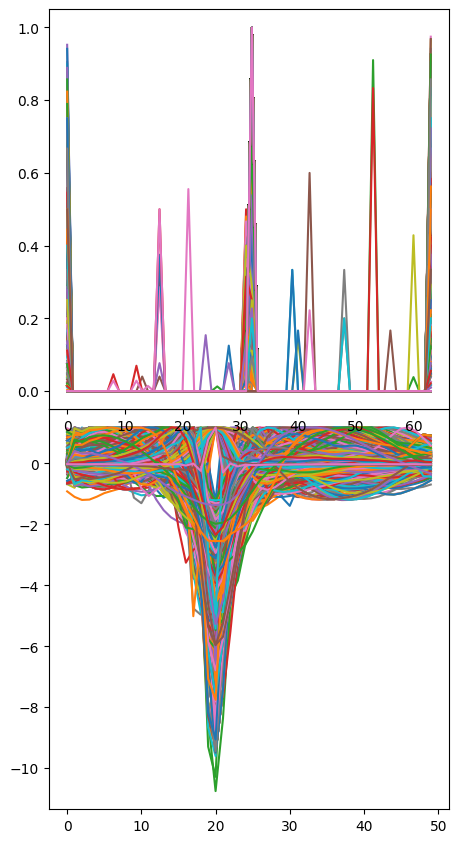

In [8]:
indices_wf = [i for i in range(0, waveforms.shape[1])]
indices_isi = [i for i in range(0, isi_dists.shape[1])]
plt.figure(figsize=(10, 10))
panel1 = plt.axes([0.1, 0.1, 0.4, 0.4])
panel2 = plt.axes([0.1, 0.5, 0.4, 0.4])

for i in range(0, waveforms.shape[0]):
    panel1.plot(indices_wf, waveforms[i])

#panel1.scatter(indices_wf, waveform[0], c='r', s=1)
for i in range(0, isi_dists.shape[0]):
    #print(isi_dist[i])
    panel2.plot(indices_isi, isi_dists[i])

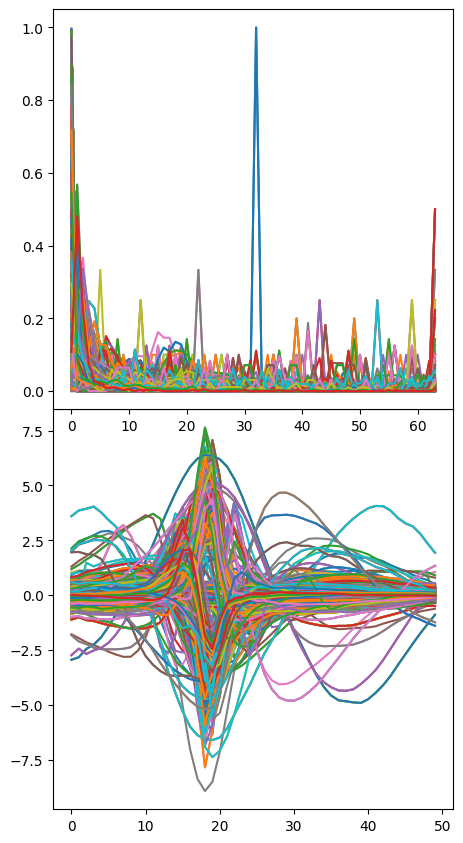

In [9]:
#Plot the data
indices_wf = [i for i in range(0, waveform.shape[1])]
indices_isi = [i for i in range(0, isi_dist.shape[1])]
plt.figure(figsize=(10, 10))
panel1 = plt.axes([0.1, 0.1, 0.4, 0.4])
panel2 = plt.axes([0.1, 0.5, 0.4, 0.4])

for i in range(0, waveform.shape[0]):
    panel1.plot(indices_wf, waveform[i])

#panel1.scatter(indices_wf, waveform[0], c='r', s=1)
for i in range(0, isi_dist.shape[0]):
    #print(isi_dist[i])
    panel2.plot(indices_isi, isi_dist[i])

In [10]:
class EphysDatasetLabeled(Dataset):
    def __init__(self, waveforms, isi_dists,labels, normalize=True):
        self.waveforms = np.array(waveforms)
        self.isi_dists = np.array(isi_dists)
        self.labels = np.array(labels)
        print(len(self.waveforms) , len(self.isi_dists), len(self.labels))
        assert len(self.waveforms) == len(self.isi_dists)
        assert len(self.waveforms) == len(self.labels)
        self.normalize = normalize
        
    def __getitem__(self, idx):
        waveform = torch.as_tensor(self.waveforms[idx, ...]).float()
        
        isi_dist = torch.as_tensor(self.isi_dists[idx, ...]).float()
        isi_dist = torch.log(isi_dist + 1)

        label = torch.as_tensor(self.labels[idx]).long()
        if self.normalize:
            #waveform = (waveform - waveform.mean()) / waveform.std()
            #0 1 normalization
            waveform = (waveform - waveform.min()) / (waveform.max() - waveform.min())
            isi_dist = (isi_dist - isi_dist.mean()) / isi_dist.std()

        waveform = waveform.view(1, 1, -1)
        waveform = F.interpolate(waveform, size=(64,), mode='linear').view(1, -1)
        
        isi_dist = isi_dist.view(1, 1, -1)
        isi_dist = F.interpolate(isi_dist, size=(64,), mode='linear').view(1, -1)

        return waveform, isi_dist, label
    
    def __len__(self):
        return len(self.waveforms)

In [11]:
def compute_class_weights(targets):
    class_counts = Counter(targets)
    total_count = len(targets)
    class_weights = {cls: total_count/count for cls, count in class_counts.items()}
    return class_weights
def create_weighted_sampler(dataset):
    targets = [dataset[i][1] for i in range(len(dataset))]
    class_weights = compute_class_weights(targets)
    weights = [class_weights[target] for target in targets]
    
    sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))
    return sampler


In [12]:
#Load EphysDatasetLabel

wf_train, isi_train,label_train = waveform[:900], isi_dist[:900], labels[:900]
wf_val, isi_val,label_val = waveform[900:], isi_dist[900:], labels[900:]

dataset_train = EphysDatasetLabeled(wf_train, isi_train, label_train, normalize=False)
sampler = create_weighted_sampler(dataset_train) #Ańadido aqui
dataloader_train = DataLoader(dataset_train, batch_size=32, sampler=sampler)

dataset_val = EphysDatasetLabeled(wf_val, isi_val, label_val, normalize=False)
sampler = create_weighted_sampler(dataset_val) #Ańadido aqui
dataloader_val = DataLoader(dataset_val, batch_size=32, sampler=sampler)
#dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=False)

#Check distribution of label train and label val
print(np.unique(label_train, return_counts=True), np.unique(label_val, return_counts=True))

900 900 900
334 334 334
(array([0, 1, 2]), array([137, 196, 567])) (array([0, 1, 2]), array([153,  49, 132]))


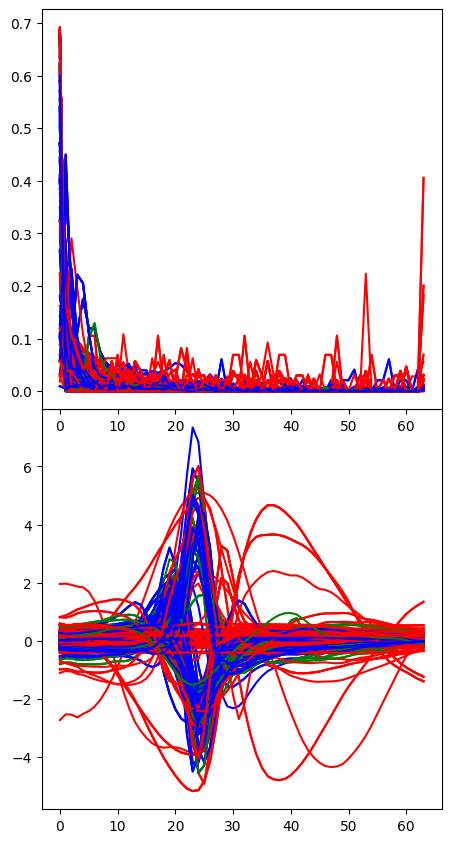

In [13]:
dataloader_waveform = []
dataloader_isi = []
dataloader_labels = []
for i, (wave, time,label) in enumerate(dataloader_val):
    dataloader_waveform.append(wave)
    dataloader_isi.append(time)
    dataloader_labels.append(label)

dataloader_waveform = torch.cat(dataloader_waveform, dim=0)
dataloader_isi = torch.cat(dataloader_isi, dim=0)
dataloader_labels = torch.cat(dataloader_labels, dim=0)

#Plot the data
indices_wf = [i for i in range(0, 64)]
indices_isi = [i for i in range(0, 64)]
plt.figure(figsize=(10, 10))
panel1 = plt.axes([0.1, 0.1, 0.4, 0.4])
panel2 = plt.axes([0.1, 0.5, 0.4, 0.4])

labelColor = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w']

for i in range(0, dataloader_waveform.shape[0]):
    panel1.plot(indices_wf, dataloader_waveform[i].squeeze().numpy(), labelColor[dataloader_labels[i].numpy()])

#panel1.scatter(indices_wf, waveform[0], c='r', s=1)
for i in range(0, dataloader_waveform.shape[0]):
    #print(isi_dist[i])
    panel2.plot(indices_isi, dataloader_isi[i].squeeze().numpy(), labelColor[dataloader_labels[i].numpy()])


    

In [14]:
#Loss function

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

class CLIPLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.register_buffer("temperature", torch.tensor(temperature))
            
    def forward(self, emb_i, emb_j):
        logits = (emb_i @ emb_j.T) / self.temperature
        emb_i_similarity = emb_i @ emb_i.T
        emb_j_similarity = emb_j @ emb_j.T

        targets = F.softmax(
            (emb_i_similarity + emb_j_similarity) / 2 * self.temperature, dim=-1
        )

        emb_i_loss = cross_entropy(logits, targets, reduction='none')
        emb_j_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (emb_i_loss + emb_j_loss) / 2.0 # shape: (batch_size)
        return loss.mean()

In [15]:
class UnimodalModel(nn.Module):
    def __init__(self, z_dim, projector=True):
        super().__init__()
        
        self.encoder = nn.Sequential(
            ResNet18Enc(z_dim=z_dim),
            nn.Linear(z_dim*2, z_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.BatchNorm1d(z_dim),
            nn.Linear(z_dim, z_dim*2),
            nn.BatchNorm1d(z_dim*2),
            ResNet18Dec(z_dim=z_dim)
        )
        
    def forward(self, x):
        x = x + torch.randn_like(x)*0.1
        enc_x = self.encoder(x)
        dec_x = self.decoder(enc_x)
        
        return enc_x, dec_x

class UnimodalEmbeddingModel(pl.LightningModule):
    def __init__(self, mode, base_model):
        super().__init__()
        assert mode in ("wave", "time")
        self.mode = mode
        self.model = base_model

        self.mse_loss = nn.MSELoss()
        self.val_loss = []
        self.train_loss = []

    def training_step(self, batch, batch_idx):
        if self.mode == "wave":
            data = batch[0]
        else:
            data = batch[1]
        
        enc, dec = self.model(data)
        loss = self.mse_loss(dec, data)
        
        norms = grad_norm(self.model.encoder, norm_type=2)
        self.log_dict(norms)
        norms = grad_norm(self.model.decoder, norm_type=2)
        self.log_dict(norms)

        self.train_loss.append(loss.item())
        self.log('train_loss', loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        if self.mode == "wave":
            data = batch[0]
        else:
            data = batch[1]
        
        enc, dec = self.model(data)
        loss = self.mse_loss(dec, data)
        
        self.val_loss.append(loss.item())
        self.log('val_loss', loss)
        
        return loss
    
    def on_validation_epoch_end(self):
        avg_loss = sum(self.val_loss) / len(self.val_loss)
        print(f"Average validation loss is {avg_loss:.2f}")
        self.val_loss = []
        
    def on_train_epoch_end(self):
        avg_loss = sum(self.train_loss) / len(self.train_loss)
        print(f"Average training loss is {avg_loss:.2f}")
        self.train_loss = []

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.01)
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8)

        return {
            "lr_scheduler": {
                "scheduler": lr_scheduler,
                "monitor": "val_loss",
            },
            "optimizer": optimizer,
        }
    
    def forward(self, x):
        return self.model(x)

In [16]:
print(len(waveforms), len(isi_dists))
print(len(waveform), len(isi_dist), len(labels))
#Concatenate waveforms and waveform
#waveforms = np.concatenate([waveforms, waveform], axis=0)

1427 1427
1234 1234 1234


In [20]:
def train_unimodal_model(mode):
    wandb.init(reinit=True)
    bs = 64
    wf_train = np.concatenate([waveforms[:1000], waveform[:800]], axis=0)
    isi_train = np.concatenate([isi_dists[:1000], isi_dist[:800]], axis=0)
    wf_val = waveforms[1000:]
    isi_val = isi_dists[1000:]

    traindata = EphysDataset(wf_train, isi_train)
    valdata = EphysDataset(wf_val, isi_val)

    train_loader = DataLoader(traindata, batch_size=bs, drop_last=True)
    val_loader = DataLoader(valdata, batch_size=bs, drop_last=True)

    base_model = UnimodalModel(z_dim=5)

    model = UnimodalEmbeddingModel(mode=mode, base_model=base_model)
    ckpt_callback = pl.callbacks.ModelCheckpoint(dirpath=f"./unimodal_model/{mode}_model_templates_noise", monitor="val_loss")

    trainer = pl.Trainer(
        logger=pl.loggers.WandbLogger(),
        callbacks=[ckpt_callback],
        log_every_n_steps=5,
        max_epochs=100,
    )

    trainer.fit(model, train_loader, val_loader)
    
    return base_model

In [21]:
class MixedModel(nn.Module):
    def __init__(self, z_dim, projector=True):
        super().__init__()
        
        self.wave_encoder = nn.Sequential(
            ResNet18Enc(z_dim=z_dim),
            nn.Linear(z_dim*2, z_dim),
        )
        
        self.wave_decoder = nn.Sequential(
            nn.BatchNorm1d(z_dim),
            nn.Linear(z_dim, z_dim*2),
            nn.BatchNorm1d(z_dim*2),
            ResNet18Dec(z_dim=z_dim)
        )

        self.time_encoder = nn.Sequential(
            ResNet18Enc(z_dim=z_dim),
            nn.Linear(z_dim*2, z_dim),
        )
        
        self.time_decoder = nn.Sequential(
            nn.BatchNorm1d(z_dim),
            nn.Linear(z_dim, z_dim*2),
            nn.BatchNorm1d(z_dim*2),
            ResNet18Dec(z_dim=z_dim)
        )
        
    def forward(self, wave, time):
        e_wave = self.wave_encoder(wave)
        e_time = self.time_encoder(time)

        # e_wave = self.wave_projector(e_wave)
        # e_time = self.time_projector(e_time)

        d_wave, d_time = self.wave_decoder(e_wave), self.time_decoder(e_time)

        return e_wave, e_time, d_wave, d_time

In [27]:
# model = MixedModel(
#     z_dim=5,
# )

# w, t = torch.randn(8, 1, 64), torch.randn(8, 1, 64)

# x,y,z,w = model(w, t)
# x.shape, y.shape, z.shape, w.shape

In [22]:
base_model = MixedModel(z_dim=5)

# with open('./unimodal_model/wave_model.pkl', 'rb') as f:
#     wave_model = pickle.load(f)

# with open('./unimodal_model/isi_model.pkl', 'rb') as f:
#     time_model = pickle.load(f)

In [23]:
wave_model = train_unimodal_model("wave")
time_model = train_unimodal_model("time")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jesusgf1 (mostajo-group). Use `wandb login --relogin` to force relogin


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory ./unimodal_model/wave_model_templates_noise exists and is not empty.

  | Name     | Type          | Params
-------------------------------------------
0 | model    | UnimodalModel | 8.0 M 
1 | mse_loss | MSELoss       | 0     
-------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
32.182    Total estimated model params 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Average validation loss is 0.56


/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.69


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.05
Average training loss is 0.07


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.07
Average training loss is 0.04


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.04


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.06
Average training loss is 0.03


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.08
Average training loss is 0.04


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.05
Average training loss is 0.03


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.08
Average training loss is 0.03


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.09
Average training loss is 0.03


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.06
Average training loss is 0.03


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.06
Average training loss is 0.03


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.04
Average training loss is 0.03


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.03


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.03


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.03


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.03
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.02
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.01
Average training loss is 0.01


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Average validation loss is 0.01
Average training loss is 0.01


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
grad_2.0_norm/0.bias,█▂▃▂▂▂▃▂▂▁▁▁▂▂▂▁▂▂▁▁▂▂▂▂▁▁▁▂▃▁▁▁▁▁▂▁▁▂▁▁
grad_2.0_norm/0.bn1.bias,█▂▄▂▂▄▇▂▄▅█▁▃▂▅▁▇▂▁▁▃▂▆▄▄▄▂▂▄▄▂▁▁▂▂▁▁▆▁▂
grad_2.0_norm/0.bn1.weight,█▁▃▂▂▄▅▂▃▄▆▂▁▃▃▁▇▁▁▁▂▂▅█▇▂▁▄▄▂▁▁▁▂▃▁▂▆▂▁
grad_2.0_norm/0.conv1.weight,█▂▃▂▂▇▃▂▃▃▅▂▁▂▂▂▄▁▁▁▂▁▂▄▃▂▁▃▂▂▁▂▁▁▂▁▁▃▁▁
grad_2.0_norm/0.layer1.0.bn1.bias,▇▃▆▃▂▄▇▂▄▅▇▂▃▂▅▂█▂▁▂▃▂▄▄▄▄▂▃▄▄▂▂▁▂▂▁▂▄▂▁
grad_2.0_norm/0.layer1.0.bn1.weight,█▂▃▂▂▆▅▂▃▃▅▁▂▃▃▁▆▁▁▁▂▂▄▇▅▄▁▃▃▂▂▂▁▁▂▁▂▅▂▁
grad_2.0_norm/0.layer1.0.bn2.bias,▇▂▄▃▂▄▇▂▄▅█▁▂▂▄▂█▂▁▁▃▂▄▄▄▃▂▃▄▃▂▁▁▂▂▁▁▅▂▁
grad_2.0_norm/0.layer1.0.bn2.weight,█▂▄▂▂▅▄▂▃▃▆▁▁▂▃▂▅▁▁▁▂▂▃▅▄▂▁▃▃▂▂▂▁▁▃▁▁▄▂▁
grad_2.0_norm/0.layer1.0.conv1.weight,█▁▃▂▂▅▄▂▂▃▆▂▁▃▃▂▄▁▁▁▂▂▃▄▄▄▁▃▂▂▂▂▁▁▂▁▁▄▁▁
grad_2.0_norm/0.layer1.0.conv2.weight,█▂▃▂▂▄▄▂▃▃▅▁▁▃▃▁▅▁▁▁▂▂▃▄▃▂▁▃▃▂▂▁▁▁▂▁▁▃▁▁


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory ./unimodal_model/time_model_templates_noise exists and is not empty.

  | Name     | Type          | Params
-------------------------------------------
0 | model    | UnimodalModel | 8.0 M 
1 | mse_loss | MSELoss       | 0     
-------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
32.182    Total estimated model params 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Average validation loss is 1.00


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 9423.24
Average training loss is 1.33


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 3.42
Average training loss is 0.71


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.67
Average training loss is 0.64


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 56.61
Average training loss is 0.51


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.65
Average training loss is 0.33


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 1.14
Average training loss is 0.27


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 4.84
Average training loss is 0.28


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.79
Average training loss is 0.27


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.67
Average training loss is 0.28


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 1.02
Average training loss is 0.40


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.93
Average training loss is 0.22


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.68
Average training loss is 0.20


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.75
Average training loss is 0.20


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.71
Average training loss is 0.19


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.82
Average training loss is 0.22


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.75
Average training loss is 0.18


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.66
Average training loss is 0.18


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.54
Average training loss is 0.14


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.49
Average training loss is 0.13


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.55
Average training loss is 0.14


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.52
Average training loss is 0.13


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.58
Average training loss is 0.12


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.53
Average training loss is 0.12


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.60
Average training loss is 0.12


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.62
Average training loss is 0.14


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.70
Average training loss is 0.16


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 1.03
Average training loss is 0.17


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.69
Average training loss is 0.15


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.51
Average training loss is 0.15


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.55
Average training loss is 0.13


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.64
Average training loss is 0.12


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.54
Average training loss is 0.10


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.46
Average training loss is 0.09


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.51
Average training loss is 0.08


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.08


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.09


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.51
Average training loss is 0.08


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.50
Average training loss is 0.08


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.54
Average training loss is 0.08


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.66
Average training loss is 0.08


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.56
Average training loss is 0.08


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.53
Average training loss is 0.08


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.51
Average training loss is 0.08


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.60
Average training loss is 0.08


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.62
Average training loss is 0.08


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.50
Average training loss is 0.07


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.66
Average training loss is 0.07


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.71
Average training loss is 0.07


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.72
Average training loss is 0.07


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.73
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.71
Average training loss is 0.07


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.69
Average training loss is 0.07


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.73
Average training loss is 0.07


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.08


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.54
Average training loss is 0.09


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.49
Average training loss is 0.07


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.71
Average training loss is 0.07


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.67
Average training loss is 0.07


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.70
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.47
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.48
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.76
Average training loss is 0.07


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.51
Average training loss is 0.07


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.67
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.54
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.62
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.74
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.74
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.69
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.64
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.64
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.55
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.74
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.69
Average training loss is 0.05


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.65
Average training loss is 0.05


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.77
Average training loss is 0.05


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.45
Average training loss is 0.05


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.58
Average training loss is 0.05


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.63
Average training loss is 0.05


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.82
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.67
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.40
Average training loss is 0.07


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.74
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.66
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.69
Average training loss is 0.05


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.67
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.63
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.67
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.36
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.48
Average training loss is 0.05


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.68
Average training loss is 0.05


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.68
Average training loss is 0.05


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.69
Average training loss is 0.05


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.80
Average training loss is 0.05


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.67
Average training loss is 0.05


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.70
Average training loss is 0.05


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.56
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.75
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

Average validation loss is 0.66
Average training loss is 0.06


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Average validation loss is 0.69
Average training loss is 0.05


In [24]:
# copy over encoder
base_model.wave_encoder = wave_model.encoder
base_model.time_encoder = time_model.encoder

# copy over decoder
base_model.wave_decoder = wave_model.decoder
base_model.time_decoder = time_model.decoder

In [25]:
torch.save(base_model.state_dict(), 'MixedAutoEncoderTemplates_noise.pt')

In [26]:
mixedModelAE = MixedModel(z_dim=5)
mixedModelAE.load_state_dict(torch.load('MixedAutoEncoderTemplates_noise.pt'))

<All keys matched successfully>

In [27]:
print(len(waveform))
print(len(isi_dist))

1234
1234


In [28]:
embedding_waveform = []
embedding_isi = []
labels = []
for i, (wave, time,label) in enumerate(dataloader_val):
    e_wave, e_time, d_wave, d_time = mixedModelAE(wave, time)
    embedding_waveform.append(e_wave)
    embedding_isi.append(e_time)
    labels.append(label)

embedding_waveform = torch.cat(embedding_waveform, dim=0)
embedding_isi = torch.cat(embedding_isi, dim=0)


In [29]:
#Run Umap in the embeddings
embedding_waveform = embedding_waveform.detach().numpy()
embedding_isi = embedding_isi.detach().numpy()
labels = torch.cat(labels, dim=0).detach().numpy()

In [30]:
#Calculate UMAP
embedding_waveform = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2).fit_transform(embedding_waveform)
embedding_isi = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2).fit_transform(embedding_isi)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [31]:
labels

array([1, 0, 2, 2, 0, 2, 0, 0, 1, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 0, 2, 0, 2, 2, 2, 2, 2,
       1, 2, 2, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 2, 2, 1, 2, 0, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 1, 1, 1, 2, 2,
       2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0,
       2, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 1, 0, 2, 2, 1, 0, 0, 0,
       0, 0, 1, 2, 0, 0, 2, 0, 2, 2, 0, 2, 1, 1, 2, 0, 2, 1, 2, 0, 0, 2,
       2, 2, 0, 2, 2, 0, 1, 1, 2, 1, 0, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 1, 2, 0, 1, 0, 2, 1, 0, 2, 2, 0, 0,
       0, 0, 1, 0, 2, 2, 0, 0, 2, 2, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 1, 0, 1, 0, 0, 0, 2, 2,
       1, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 2,
       2, 0, 2, 2, 0, 2, 2, 0, 1, 0, 2, 0, 0, 1, 0, 2, 0, 2, 1, 2, 0, 0,
       2, 1, 2, 0, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2,

In [32]:
labelColor = ['r', 'g', 'b']

In [33]:
labelColor = [labelColor[label] for label in labels]

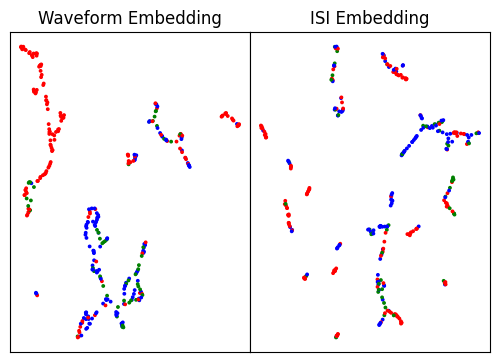

In [34]:
#Plot the embeddings
figureWidth=6
figureHeight=4
plt.figure(figsize=(figureWidth,figureHeight))
panel1 = plt.axes([0.1, 0.1, 0.4, 0.8])
panel2 = plt.axes([0.5, 0.1, 0.4, 0.8])

panel1.scatter(embedding_waveform[:, 0], embedding_waveform[:, 1], color=labelColor, s=3)
panel1.set_title("Waveform Embedding")
panel1.set_xticks([])
panel1.set_yticks([])
panel2.scatter(embedding_isi[:, 0], embedding_isi[:, 1], color=labelColor, s=3)
panel2.set_title("ISI Embedding")
panel2.set_xticks([])
panel2.set_yticks([])
plt.show()




In [48]:
from torch.nn.functional import normalize
class classification(nn.Module):
    def __init__(self, num_labels, **kwargs):
        super().__init__()
        self.mixedModelAE = MixedModel(**kwargs)
        self.mixedModelAE.load_state_dict(torch.load('MixedAutoEncoderTemplates.pt'))
        for p in self.mixedModelAE.parameters():
            p.requires_grad = False
        
        #self.classifier = nn.Sequential(nn.Linear(kwargs['z_dim'] * 2, num_labels))
        self.classifier = nn.Sequential(nn.Linear(kwargs['z_dim'] * 2, 64), nn.ReLU(),
                                         nn.Linear(64, num_labels))
        #self.classifier = nn.Sequential(nn.Linear(64 * 2, num_labels))
        

    def forward(self, wave,time):
        e_wave, e_time, d_wave, d_time = self.mixedModelAE(wave,time)
        e_wave, e_time = normalize(e_wave), normalize(e_time)
        x = torch.cat((e_wave, e_time), dim=-1).squeeze()
        #print(x.shape)
        output = self.classifier(x)        
        return output

classifier = classification(num_labels=3, z_dim=5)

In [50]:
from sklearn.utils.class_weight import compute_class_weight
class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(labels), y=labels)
class_weights=torch.tensor(class_weights,dtype=torch.float)

In [51]:
class_weights

tensor([0.7277, 2.0617, 0.8766])

In [52]:
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

#Training the classifier

def train_classifier(classifier, optim, loss_fn, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        cum_loss = 0
        classifier.train()
        correct_train = 0
        total_train = 0
        for i, (wave, time,label) in enumerate(train_loader):
            optimizer.zero_grad()
            output = classifier(wave,time)
            train_predicted = torch.argmax(output, 1)
            total_train += time.size(0)
            correct_train += (train_predicted == label).sum().item()
            loss = loss_fn(output,label)
            cum_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch} Iter {i} Loss {cum_loss/len(train_loader)}")
        print(f"Epoch {epoch} Iter {i} Train Accuracy {correct_train / total_train}")
        classifier.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (wave, time,label) in enumerate(val_loader):
                output = classifier(wave,time)
                predicted = torch.argmax(output, 1)
                #print(predicted.shape)
                total += time.size(0)
                correct += (predicted == label).sum().item()
            print(f"Epoch {epoch} Validation Accuracy {correct / total}")
        


In [53]:
train_classifier(classifier, optimizer, loss_fn, dataloader_train, dataloader_val, epochs=25)

Epoch 0 Iter 28 Loss 1.0185218658940545
Epoch 0 Iter 28 Train Accuracy 0.5677777777777778
Epoch 0 Validation Accuracy 0.39221556886227543
Epoch 1 Iter 28 Loss 0.9065471003795492
Epoch 1 Iter 28 Train Accuracy 0.6266666666666667
Epoch 1 Validation Accuracy 0.3532934131736527
Epoch 2 Iter 28 Loss 0.8813151758292626
Epoch 2 Iter 28 Train Accuracy 0.6322222222222222
Epoch 2 Validation Accuracy 0.40119760479041916
Epoch 3 Iter 28 Loss 0.8960131242357451
Epoch 3 Iter 28 Train Accuracy 0.63
Epoch 3 Validation Accuracy 0.4221556886227545
Epoch 4 Iter 28 Loss 0.8765642992381392
Epoch 4 Iter 28 Train Accuracy 0.6311111111111111
Epoch 4 Validation Accuracy 0.37425149700598803
Epoch 5 Iter 28 Loss 0.8813127155961662
Epoch 5 Iter 28 Train Accuracy 0.6422222222222222
Epoch 5 Validation Accuracy 0.41317365269461076
Epoch 6 Iter 28 Loss 0.8835263293364952
Epoch 6 Iter 28 Train Accuracy 0.6322222222222222
Epoch 6 Validation Accuracy 0.38622754491017963
Epoch 7 Iter 28 Loss 0.9380496349827997
Epoch 7 It

In [54]:
#Predict with the classifier

def predict_classifier(classifier, dataloader):
    predictions = []
    classifier.eval()
    with torch.no_grad():
        for i, (wave, time,label) in enumerate(dataloader):
            output = classifier(wave,time)
            predicted = torch.argmax(output, 1)
            predictions.append(predicted)
    return predictions

predictions = predict_classifier(classifier, dataloader_val)
predictions = torch.cat(predictions, dim=0).detach().numpy()

In [55]:
len(predictions)

334

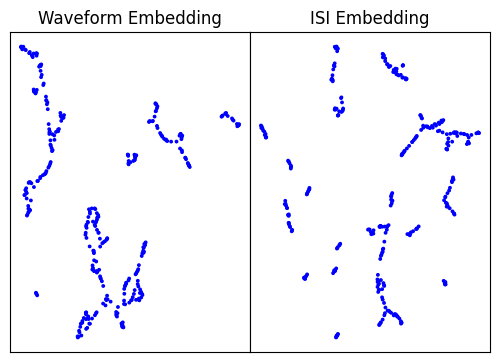

In [56]:
labelColor = ['r', 'g', 'b']
labelColor = [labelColor[label] for label in predictions]
#Plot the embeddings
figureWidth=6
figureHeight=4
plt.figure(figsize=(figureWidth,figureHeight))
panel1 = plt.axes([0.1, 0.1, 0.4, 0.8])
panel2 = plt.axes([0.5, 0.1, 0.4, 0.8])

panel1.scatter(embedding_waveform[:, 0], embedding_waveform[:, 1], color=labelColor, s=3)
panel1.set_title("Waveform Embedding")
panel1.set_xticks([])
panel1.set_yticks([])
panel2.scatter(embedding_isi[:, 0], embedding_isi[:, 1], color=labelColor, s=3)
panel2.set_title("ISI Embedding")
panel2.set_xticks([])
panel2.set_yticks([])
plt.show()